In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import torchvision.transforms as transforms
import torchvision
import torch.optim as optim
from torchvision.utils import save_image

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
nz = 100
num_classes = 10
d_lr = 0.0002
g_lr = 0.0002

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class netG(nn.Module):
    def __init__(self, lenz):
        super(netG, self).__init__()
        self.lenz = lenz
        self.l = nn.Linear(110,384)

        self.t1 = nn.ConvTranspose2d(384, 192, 6, (2,2))
        self.bn1 = nn.BatchNorm2d(192)
        self.t2 = nn.ConvTranspose2d(192, 96, 5, (2, 2))
        self.bn2 = nn.BatchNorm2d(96)
        
        self.t3 = nn.ConvTranspose2d(96, 3, 4, (2, 2))
        

    def forward(self, x:torch.Tensor):
#         print(x.shape)
        x = x.view(-1, self.lenz)
#         print(x.shape)
        x = self.l(x).view(-1, 384, 1, 1)
#         print(x.shape)
        x = F.relu(self.bn1(self.t1(x)))
#         print(x.shape)
        x = F.relu(self.bn2(self.t2(x)))
#         print(x.shape)
        x = F.tanh(self.t3(x))
#         print(x.shape)
        return x


class netD(nn.Module):
    def __init__(self, num_classes):
        super(netD, self).__init__()
        self.c1 = nn.Conv2d(3, 16, (3, 3), (2, 2), 1)
        self.c2 = nn.Conv2d(16, 32, (3, 3), (1, 1), 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.c3 = nn.Conv2d(32, 64, (3, 3), (2, 2), 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.c4 = nn.Conv2d(64, 128, (3, 3), (1, 1), 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.c5 = nn.Conv2d(128, 256, (3, 3), (2, 2), 1)
        self.bn4 = nn.BatchNorm2d(256)
        self.c6 = nn.Conv2d(256, 512, (3, 3), (1, 1), 1)
        self.bn5 = nn.BatchNorm2d(512)
        self.d1 = nn.Linear(4 * 4 * 512, 1)
        self.d2 = nn.Linear(4 * 4 * 512, num_classes)

    def forward(self, x:torch.Tensor):
#         print(x.shape)
        x = F.dropout(F.leaky_relu(self.c1(x)),0.5)
        x = F.dropout(self.bn1(F.leaky_relu(self.c2(x),.2)),0.5)
        x = F.dropout(self.bn2(F.leaky_relu(self.c3(x),.2)),0.5)
        x = F.dropout(self.bn3(F.leaky_relu(self.c4(x),.2)),0.5)
        x = F.dropout(self.bn4(F.leaky_relu(self.c5(x),.2)),0.5)
        x = F.dropout(self.bn5(F.leaky_relu(self.c6(x),.2)),0.5)
        x = x.view(-1, 4 * 4 * 512)
        real_or_fake = self.d1(x)
        classes = self.d2(x)
        return real_or_fake, classes
    
def sample_image(n_row, batches_done, generator):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    batch_size = n_row ** 2
    noise = np.random.normal(0, 1, (batch_size, nz))
    np_gen_label = np.random.randint(0, num_classes, batch_size)
    onehot = np.zeros((batch_size, num_classes))
    onehot[np.arange(batch_size), np_gen_label] = 1
    z = np.concatenate((noise, onehot), axis=1)
    z = torch.from_numpy(z).float().to(device)
    
    
    gen_imgs = generator(z)
    save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)

In [3]:
def train(net_g, net_d, epochs, batch_size, lr, log_every_n=50):
    """
    Training a network
    :param net: Network for training
    :param epochs: Number of epochs in total.
    :param batch_size: Batch size for training.
    """
    print('==> Preparing data..')
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

    ])
    best_acc = 0  # best test accuracy
    start_epoch = 0  # start from epoch 0 or last checkpoint epoch
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=0)

    d_criterion = nn.BCEWithLogitsLoss()
    aux_criterion = nn.CrossEntropyLoss()

    d_optmizer = optim.Adam(net_d.parameters(), d_lr, (.5, .999))
    g_optimizer = optim.Adam(net_g.parameters(), g_lr, (.5, .999))

    global_steps = 0
    start = time.time()

    real_targ = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
    fake_targ = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)
    dlosses = []
    glosses = []
    
    for epoch in range(start_epoch, epochs):
        """
        Start the training code.
        """
        print('\nEpoch: %d' % epoch)
        net_g.train()
        net_d.train()
        train_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            g_optimizer.zero_grad()

            # train generator
            noise = np.random.normal(0, 1, (batch_size, nz))
            np_gen_label = np.random.randint(0, num_classes, batch_size)
            onehot = np.zeros((batch_size, num_classes))
            onehot[np.arange(batch_size), np_gen_label] = 1
            z = np.concatenate((noise, onehot), axis=1)
            z = torch.from_numpy(z).float().to(device)

            gen_label = torch.from_numpy(np_gen_label).long().to(device)


            gen_im = net_g(z)
            gen_im_validity, gen_im_class = net_d(gen_im)
            g_tricks_d = d_criterion(gen_im_validity, real_targ)
            g_label_correct = aux_criterion(gen_im_class, gen_label)
            g_loss = g_tricks_d + g_label_correct
            g_loss.backward()

            g_optimizer.step()

            # train discriminator
            d_optmizer.zero_grad()

            gen_label = torch.from_numpy(np_gen_label).long().to(device)

            gen_im = net_g(z)
            gen_im_validity, gen_im_class = net_d(gen_im)

#             print(gen_im_validity, fake_targ)
#             print(aux_criterion(gen_im_class, gen_label))
            d_fake_loss = d_criterion(gen_im_validity, fake_targ) + aux_criterion(gen_im_class, gen_label)

            real_im_validity, real_im_class = net_d(inputs)
#             print(d_criterion(real_im_validity, real_targ))
#             print(aux_criterion(real_im_class, targets))
            

            d_real_loss = d_criterion(real_im_validity, real_targ) + aux_criterion(real_im_class, targets)

        
            if d_fake_loss.item()<0:
                print("issue:")
                print(d_criterion(gen_im_validity, fake_targ))
                print(aux_criterion(gen_im_class, gen_label))
                print(gen_im_validity)
                print(gen_im_class)
            d_loss = (d_real_loss + d_fake_loss) / 2

            d_loss.backward()

            d_optmizer.step()
        if epoch %5==0:
            sample_image(5, epoch, net_g)

#             if global_steps % log_every_n == 0:
#                 end = time.time()
#                 num_examples_per_second = log_every_n * batch_size / (end - start)
        print("G Loss: %f\nD Loss %f"
              % (g_loss.item(), d_loss.item()))
        print("")
        if epoch%50==0:
            torch.save(net_g.state_dict(), '%s/netG_epoch_%d.pth' % ('models', epoch))
            torch.save(net_d.state_dict(), '%s/netD_epoch_%d.pth' % ('models', epoch))
#                 start = time.time()
        glosses.append(g_loss.item())
        dlosses.append(d_loss.item())
    return net_g, net_d, dlosses, glosses

In [4]:
net_g = netG(nz+num_classes).to(device)
net_g.apply(weights_init)
net_d = netD(num_classes).to(device)
net_d.apply(weights_init)

net_g, net_d, dlosses, glosses = train(net_g, net_d, 500, 500, 0.0002, log_every_n=50)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified

Epoch: 0


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


G Loss: 7.690615
D Loss 2.514539


Epoch: 1
G Loss: 8.619022
D Loss 2.329136


Epoch: 2
G Loss: 6.774495
D Loss 2.466087


Epoch: 3
G Loss: 4.551645
D Loss 2.385903


Epoch: 4
G Loss: 4.911558
D Loss 1.985769


Epoch: 5
G Loss: 2.756240
D Loss 2.054858


Epoch: 6
G Loss: 3.830194
D Loss 1.583306


Epoch: 7
G Loss: 3.173809
D Loss 1.672179


Epoch: 8
G Loss: 2.031721
D Loss 1.525274


Epoch: 9
G Loss: 1.841231
D Loss 1.854333


Epoch: 10
G Loss: 2.949426
D Loss 1.493942


Epoch: 11
G Loss: 2.083033
D Loss 1.494877


Epoch: 12
G Loss: 2.435699
D Loss 1.643224


Epoch: 13
G Loss: 2.321439
D Loss 1.494023


Epoch: 14
G Loss: 3.368190
D Loss 1.550938


Epoch: 15
G Loss: 2.082529
D Loss 1.438316


Epoch: 16
G Loss: 2.778293
D Loss 1.472741


Epoch: 17
G Loss: 2.468297
D Loss 1.259095


Epoch: 18
G Loss: 4.843547
D Loss 1.743855


Epoch: 19
G Loss: 2.463864
D Loss 1.473576


Epoch: 20
G Loss: 2.679958
D Loss 1.458472


Epoch: 21
G Loss: 3.623044
D Loss 1.424744


Epoch: 22
G Loss: 1.511398
D 

In [5]:
torch.save(net_g.state_dict(), '%s/netG_epoch_500.pth' % ('models'))
torch.save(net_d.state_dict(), '%s/netD_epoch_500.pth' % ('models'))

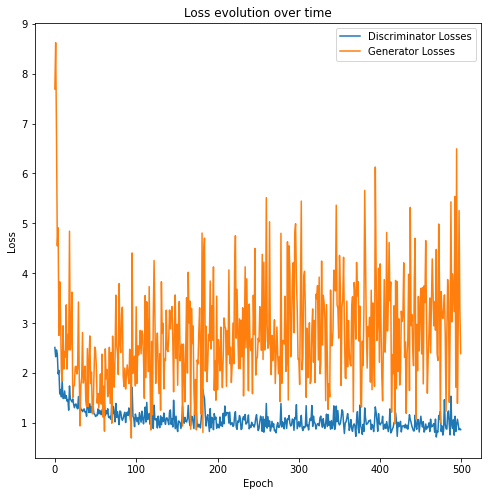

In [7]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8,8))
x = [i for i in range(0,500)]
plt.plot(x,dlosses, label="Discriminator Losses")
plt.plot(x,glosses, label="Generator Losses")
plt.legend()
plt.title("Loss evolution over time")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [9]:
def test_image(generator, f_name):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    batch_size = 50
    noise = np.random.normal(0, 1, (batch_size, nz))
    np_gen_label = np.concatenate([np.arange(10) for i in range(5)])
    onehot = np.zeros((batch_size, num_classes))
    onehot[np.arange(batch_size), np_gen_label] = 1
    z = np.concatenate((noise, onehot), axis=1)
    z = torch.from_numpy(z).float().to(device)
    
    
    gen_imgs = generator(z)
    save_image(gen_imgs.data, "original_model/summary_images/"+f_name+'.png', nrow=10, normalize=True)

#     npimg = gen_imgs.cpu().detach().numpy()
#     for i in range(30):
#         print(npimg[i])
#         plt.subplot(3,10,i+1)
#         plt.imshow(np.transpose(npimg[i], (1,2,0)), interpolation='nearest')
#     plt.show()
# test_image(net_g)

In [10]:
net_g = netG(110).to('cuda')
for i in range(11):
    epoch = str(int(50*i))
    PATH = 'original_model/models/netG_epoch_'+epoch+'.pth'
    
    net_g.load_state_dict(torch.load(PATH))
    net_g.eval()
    
    test_image(net_g, epoch)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
